In [1]:
#Quantum Approximate Optimization Algorithm - This is it
import cirq
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit, circuit_to_svg

In [8]:
#Functions (a)
def chooseHp():
    H = np.array([[0]*4]*12) #qubit indices ijk (1-6) and coefficient W_ijk(+-1) {Q_i, Q_j, Q_k, V_ijk}
    check = np.array([0]*6) #keeps track of all indices that have been chosen

    #12 triplets
    for x in range(12):
        free = [0,1,2,3,4,5] #remaining qubit options(each can be chosen once)
        #3 qubits
        for y in range(3):
            qindex = free[random.randint(0,len(free)-1)]
            free.remove(qindex)
            H[x,y] = qindex
            check[qindex] = 1
        #Coefficient
        H[x, 3] = (-1) ** random.randint(0, 1)

    #If an index hasn't been chosen, redo
    for x in range(6):
        if check[x] == 0:
            return chooseHp()
        else:
            return H

def findEnergy(state, H_p):
    #Calculate the energy of a state
    energy = 0
    #For each triplet of h_p if the qubits are 1 in the state, multiply by 1 else -1 (-1*1*-1)
    for triplet in H_p:
            weight = 1
            for i in range(3):
                if state[triplet[i]]:
                    weight *= 1
                else:
                    weight *= -1
            weight *= triplet[3]#then scale by the weight
            energy += weight#energy is the sum of the 12 weights
    return energy

#Classical search for ground state energy
def findGround(H_p):
    ground_energy = 13
    
    #build the state vector - all 64 options
    stateList = []
    for a in range(2):
        for b in range(2):
            for c in range(2):
                for d in range(2):
                    for e in range(2):
                        for f in range(2):
                            estate = [a,b,c,d,e,f,0]#The last index is the energy of the state
                            stateList.append(estate)

    #Calculate the energy of each state
    for state in stateList:
        state[6] = findEnergy(state, H_p)
        #update the ground state energy - its always even since there are an even # of triplets
        ground_energy = min(ground_energy, state[6])
    
    #Find ground states
    ground_state = []
    for state in stateList:
        if state[6] == ground_energy:
            ground_state.append(state)
    
    return(ground_state)

#Cant mix lists and generators in python
def rotation3Z(q0, q1, q2, anc, angle):
    oplist = []
    oplist.append(cirq.CNOT(q0, anc))
    oplist.append(cirq.CNOT(q1, anc))
    oplist.append(cirq.CNOT(q2, anc))
    oplist.append(cirq.rz(2 * angle)(anc))
    oplist.append(cirq.CNOT(q2, anc))
    oplist.append(cirq.CNOT(q1, anc))
    oplist.append(cirq.CNOT(q0, anc))
    return oplist

def QAOA_1(qbit, ancilla, H_p ,alpha, beta):
    #|ψ) → e^iβH_D*e^iαH_P|ψ) : 
    oplist = []
    #Add Hadamards
    for q in qbit:
        oplist.append(cirq.H(q))
    #Add H_p: 3 qubit Z rotations
    for triple in H_p:
        oplist.append(rotation3Z(qbit[triple[0]], qbit[triple[1]], qbit[triple[2]], ancilla, alpha))
    #Add single X rotations
    for q in qbit:
        oplist.append(cirq.rx(-beta)(q))
    #Measure
    oplist.append(cirq.measure(*qbit,key='z'))
    
    return oplist

#Convert state key into proper format (binary list)
def key_to_state(key, qubits):
    binaryformat = "{0:0" + str(len(qubits)) + "b}"
    bitstate = binaryformat.format(int(key))#Convert to binary to get the state as a string
    state = [0]*len(qubits)
    for i in range(len(bitstate)):
        if bitstate[i] == '1':
            state[i] = 1
    return state
    

#Finds the expectation value of a measurement in the z basis
def expectHp(oplist, qubits, H_p, gs_energy):
    sim = cirq.Simulator()
    circuit = cirq.Circuit(oplist)
    
    counts = 1000
    samples = sim.run(circuit, repetitions=counts)
    data = samples.histogram(key='z')#Returns the state and the number of times it was hit
    
    energy_avg = 0 #The average energy of the resulting state for the circuit
    ground_avg = 0 #Average times a ground state was hit
    
    #Dictionary: key = qubit state measurement, value = number of results
    for key, value in data.items():
        true_state = key_to_state(int(key), qubits)#Get the state it hit
        energy3Z = findEnergy(true_state, H_p)#The energy of the state
        energy_avg += int(value) * energy3Z
        if energy3Z == gs_energy:#The state is a ground state
            ground_avg += int(value)
        
    energy_avg /= counts
    ground_avg /= counts
    return [energy_avg, ground_avg]

In [9]:
#Initialize Problem
H_p = chooseHp()
ground = findGround(H_p)
ground_energy = ground[0][6]
print("Ground Energy: ", ground_energy)

Ground Energy:  -8


[-0.026, 0.015]


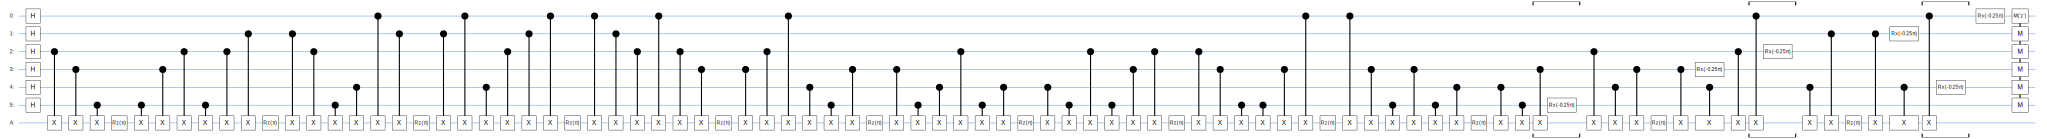

In [10]:
#Single Run Simulation
#'''
alpha = np.pi/2
beta = np.pi/4
qbits = cirq.LineQubit.range(6)
anc = cirq.NamedQubit("A")
ops = QAOA_1(qbits, anc, H_p, alpha, beta)
print(expectHp(ops, qbits, H_p, ground_energy))
SVGCircuit(cirq.Circuit(ops)) #nice circuit
#'''


In [11]:
#Scan Angles (b)
qbits = cirq.LineQubit.range(6)
anc = cirq.NamedQubit("A")
angles = np.pi/2 * np.arange(-1,1,.2)
best = [0,0,0,0]

for a in angles:
    for b in angles:
        ops = QAOA_1(qbits, anc, H_p, a, b)
        expect = expectHp(ops, qbits, H_p, ground_energy)
        current = [expect[0], expect[1], int(a*180/np.pi), int(b*180/np.pi)]
        if expect[1] > best[1]:
            best = current

print("Energy","P(GS)","Alpha", "Beta")
print(best)

Energy P(GS) Alpha Beta
[-0.842, 0.073, 17, 53]


In [12]:
#Bonus - two layers of QAOA (c)
def QAOA_p(qbit, ancilla, H_p ,aList, bList):
    #|ψ) → e^iβH_D*e^iαH_P|ψ) : 
    oplist = []
    #Add Hadamards
    for q in qbit:
        oplist.append(cirq.H(q))
        
    for i in range(len(aList)):
        #Add H_p: 3 qubit Z rotations
        for triple in H_p:
            oplist.append(rotation3Z(qbit[triple[0]], qbit[triple[1]], qbit[triple[2]], ancilla, aList[i]))
        #Add single X rotations
        for q in qbit:
            oplist.append(cirq.rx(-bList[i])(q))
        
    #Measure
    oplist.append(cirq.measure(*qbit,key='z'))
    
    return oplist

#Scan Angles for p layers
qbits = cirq.LineQubit.range(6)
anc = cirq.NamedQubit("A")
angles = np.pi/2 * np.arange(-.5,.5,.2)
best = [0,0,0,0,0,0]

for a1 in angles:
    for a2 in angles:
        for b1 in angles:
            for b2 in angles:
                alist = [a1,a2]
                blist = [b1,b2]
                ops = QAOA_p(qbits, anc, H_p, alist, blist)
                expect = expectHp(ops, qbits, H_p, ground_energy)
                current = [expect[0], expect[1], int(a1*180/np.pi), int(a2*180/np.pi), int(b1*180/np.pi), int(b2*180/np.pi)]
                if expect[1] > best[1]:
                    best = current

print("Energy","P(GS)","A1", "A2","B1", "B2")
print(best)

Energy P(GS) A1 A2 B1 B2
[-1.684, 0.075, -27, 9, 27, -45]
